In [3]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import random
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)

dataset = dataset.fillna(0)
# print(dataset.columns)
# print(dataset.shape)
# print(dataset.tail())


# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 60
TRAIN_BATCH_SIZE = 593                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_COUNT = 7
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))
# print("batch size: {}".format(BATCH_SIZE))

test_seq_count = TEST_BATCH_COUNT * TEST_BATCH_SIZE


# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:-test_seq_count].reshape(-1, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-test_seq_count:].reshape(-1, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)      # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_SIZE = train.shape[1]
TRAIN_BATCH_COUNT = train.shape[0]
TEST_BATCH_SIZE = test.shape[1]
TEST_BATCH_COUNT = test.shape[0]

train = torch.tensor(train)
test  = torch.tensor(test)

# train = rolling_data[:train_batch_count, :, :, :]
# test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (600, 60, 135)
seq count: 600
seq length: 60
train_x: torch.Size([1, 593, 60, 134])
train_y: torch.Size([1, 593, 1, 1])
test_x:  torch.Size([7, 1, 60, 134])
test_y:  torch.Size([7, 1, 1, 1])
train_batch_count: 1
test_batch_count:  7


In [4]:
# 定义 LSTM 模型

np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

TIME_STEP = SEQ_LENGTH                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
INPUT_SIZE = dataset.shape[1]-1
HIDDEN_SIZE = 768
NUM_LAYERS = 3

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        # self.h0 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        # self.c0 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        
        self.init_weights2()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def init_weights2(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
    
    def init_weights3(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x, hidden, cell):
        batchsize = x.shape[0]

        # layer 1
        # x = self.linear_1(x)
        x = self.dropout(x)

        # lstm_out, (h_n, c_n) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        
        lstm_out, (h_n, c_n) = self.lstm(x, (hidden, cell))
        
        lstm_out = self.dropout(lstm_out)

        # lstm_out = self.dropout(lstm_out)
        
        predictions = self.linear_2(lstm_out)
        return predictions, h_n, c_n


In [3]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.double().to(device)
LR = 1e-5
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

In [4]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epoches = 1000
epoch_loss = 0
epoch_loss_list = []
train_batch_count = train_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).double().to(device)

for epoch in range(epoches):
    for step in range(train_batch_count):
        pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(pred[:,-1], train_y[step][:,-1])                # Compare the all sequences' last element in one batch
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data.cpu()
        
    if epoch_loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, epoches, loss.item()))
        print("The loss value is reached")
        break

    print("{} of {} epoch loss: {:.4f} with lr: {}".format(epoch, epoches, epoch_loss.item(), optimizer.state_dict()['param_groups'][0]['lr']))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    
    if (epoch+1) % 2000 ==0:
        scheduler.step()
    # print("learning rate: {}".format(optimizer.state_dict()['param_groups'][0]['lr']))
    # for p in optimizer.param_groups:
    #     p['lr'] *= 0.99
    
plt.plot(epoch_loss_list)
plt.show()    

0 of 1000 epoch loss: 0.0242 with lr: 1e-05
1 of 1000 epoch loss: 0.0178 with lr: 1e-05
2 of 1000 epoch loss: 0.0149 with lr: 1e-05
3 of 1000 epoch loss: 0.0140 with lr: 1e-05
4 of 1000 epoch loss: 0.0137 with lr: 1e-05
5 of 1000 epoch loss: 0.0148 with lr: 1e-05
6 of 1000 epoch loss: 0.0150 with lr: 1e-05
7 of 1000 epoch loss: 0.0131 with lr: 1e-05
8 of 1000 epoch loss: 0.0144 with lr: 1e-05
9 of 1000 epoch loss: 0.0133 with lr: 1e-05
10 of 1000 epoch loss: 0.0121 with lr: 1e-05
11 of 1000 epoch loss: 0.0120 with lr: 1e-05
12 of 1000 epoch loss: 0.0119 with lr: 1e-05
13 of 1000 epoch loss: 0.0129 with lr: 1e-05
14 of 1000 epoch loss: 0.0128 with lr: 1e-05
15 of 1000 epoch loss: 0.0124 with lr: 1e-05
16 of 1000 epoch loss: 0.0133 with lr: 1e-05
17 of 1000 epoch loss: 0.0123 with lr: 1e-05
18 of 1000 epoch loss: 0.0122 with lr: 1e-05
19 of 1000 epoch loss: 0.0122 with lr: 1e-05
20 of 1000 epoch loss: 0.0124 with lr: 1e-05
21 of 1000 epoch loss: 0.0116 with lr: 1e-05
22 of 1000 epoch los

KeyboardInterrupt: 

In [ ]:
# 保存模型
torch.save(model, 'e:\\Model_LSTM1.pkl')

In [ ]:
# 加载模型
model = torch.load('e:\\Model_LSTM1.pkl')

Prediction Loss average:0.006330
Prediction: -0.05
Actual:     0.00


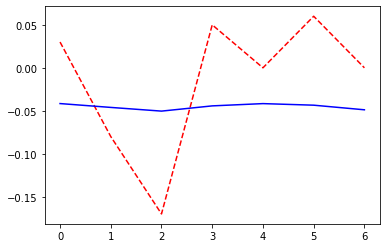

In [5]:
# 用模型预测数据
model.eval()
test_loss = 0
test_batch_count = test_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).double().to(device)

actual_line=[]
pred_line=[]

for step in range(test_batch_count):
    pred, hn, cn = model(test_x[step], h0, c0)
    
    h0, c0 = hn.detach(), cn.detach()

    loss = loss_func(pred[:,-1], test_y[step][:,-1])                # Compare the all sequences' last element in one batch
    
    test_loss += loss.cpu()
    
    actual_line.append(test_y[step][-1,-1].item())
    pred_line.append(pred[-1,-1].item())
        
print("Prediction Loss average:{:.6f}".format(test_loss.data/(step+1)))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))

# actual_line = test_y[step][-1].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
# pred_line   = pred[-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()


In [ ]:
# 下面Train除了最后一个Sequence，再用最后一个Sequence来预测

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)

dataset = dataset.fillna(0)



# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 60
TRAIN_BATCH_SIZE = 599                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_COUNT = 1
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

test_seq_count = TEST_BATCH_COUNT * TEST_BATCH_SIZE

train = rolling_data[:-test_seq_count].reshape(1, -1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-test_seq_count:].reshape(-1, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)      # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_SIZE = train.shape[1]
TRAIN_BATCH_COUNT = train.shape[0]
TEST_BATCH_SIZE = test.shape[1]
TEST_BATCH_COUNT = test.shape[0]

train = torch.tensor(train)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)



model = LSTMModel(input_size=X_DIM, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.double().to(device)
LR = 1e-5
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)



model.train()
epoches = 200
epoch_loss = 0
epoch_loss_list = []
train_batch_count = train_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, 599, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, 599, HIDDEN_SIZE).double().to(device)

for epoch in range(epoches):
    for step in range(train_batch_count):
        pred, hn, cn = model(train_x[step], h0, c0)
        # h0, c0 = hn.detach(), cn.detach()
        loss = loss_func(pred[:,-1], train_y[step][:,-1])                # Compare the all sequences' last element in one batch
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data.cpu()
        
    if epoch_loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, epoches, loss.item()))
        print("The loss value is reached")
        break

    print("{} of {} epoch loss: {:.4f} with lr: {}".format(epoch, epoches, epoch_loss.item(), optimizer.state_dict()['param_groups'][0]['lr']))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0

    

model.eval()
test_loss = 0
test_batch_count = test_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).double().to(device)
c0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).double().to(device)

actual_line=[]
pred_line=[]

for step in range(test_batch_count):
    pred, hn, cn = model(test_x[step], h0, c0)
    
    h0, c0 = hn.detach(), cn.detach()

    loss = loss_func(pred[:,-1], test_y[step][:,-1])                # Compare the all sequences' last element in one batch
    
    test_loss += loss.cpu()
    
    actual_line.append(test_y[step][-1,-1].item())
    pred_line.append(pred[-1,-1].item())
        
print("Prediction Loss average:{:.6f}".format(test_loss.data/(step+1)))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))